<a href="https://colab.research.google.com/github/WafaSanaa/Computer_Vision/blob/main/Brain_Tumor_Segmentation_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil



In [32]:
from google.colab import files
uploaded = files.upload()

Saving brain.zip to brain.zip


In [34]:
import zipfile
import os

# Créer un dossier où extraire
extract_path = '/content/brain'
os.makedirs(extract_path, exist_ok=True)

# Décompression
with zipfile.ZipFile('brain.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Décompression terminée.")

✅ Décompression terminée.


In [35]:
import os

# Affiche les premiers fichiers et dossiers extraits
for root, dirs, files in os.walk(extract_path):
    print("📁", root)
    print("📄", files[:5])  # n'affiche que les 5 premiers fichiers
    break

📁 /content/brain
📄 []


# **InterRussia 2024 - Brain Tumor Segmentation**

# 1. Set up

In [36]:
import os
import random
import numpy as np
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML
from tqdm import tqdm
from sklearn.model_selection import KFold


In [37]:
!pip install -U torchmetrics

In [38]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.transforms.functional import to_tensor

# Install torchmetrics if it's not already installed
try:
    import torchmetrics
except ModuleNotFoundError:
    !pip install -q torchmetrics
    import torchmetrics

# Import Dice from the correct submodule
# Dice for segmentation is often found in the classification submodule
from torchmetrics.segmentation import DiceScore

try:
    import segmentation_models_pytorch as smp
except ModuleNotFoundError:
    !pip install -q segmentation-models-pytorch
    import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import KFold
from tqdm import tqdm

In [39]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed for reproducibility
RANDOM_SEED = 2024
set_seed(RANDOM_SEED)

# 2. Visualize some original images

# 2.1. Get Images and Masks Paths

In [40]:
image_dir = '/content/brain/brain_tumor_dataset/yes'
mask_dir = '/content/brain/brain_tumor_dataset/no'

image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]
mask_paths = [os.path.join(mask_dir, filename) for filename in os.listdir(mask_dir)]

print(f'{len(image_paths)} images and {len(mask_paths)} masks.')

155 images and 98 masks.


In [41]:
# Check each image has a corresponding mask
for image_path in image_paths:
    if image_path.replace('/images/', '/masks/') not in mask_paths:
        print(image_path)

/content/brain/brain_tumor_dataset/yes/Y22.jpg
/content/brain/brain_tumor_dataset/yes/Y59.JPG
/content/brain/brain_tumor_dataset/yes/Y98.JPG
/content/brain/brain_tumor_dataset/yes/Y10.jpg
/content/brain/brain_tumor_dataset/yes/Y44.JPG
/content/brain/brain_tumor_dataset/yes/Y92.jpg
/content/brain/brain_tumor_dataset/yes/Y186.jpg
/content/brain/brain_tumor_dataset/yes/Y106.jpg
/content/brain/brain_tumor_dataset/yes/Y74.jpg
/content/brain/brain_tumor_dataset/yes/Y160.JPG
/content/brain/brain_tumor_dataset/yes/Y7.jpg
/content/brain/brain_tumor_dataset/yes/Y169.jpg
/content/brain/brain_tumor_dataset/yes/Y6.jpg
/content/brain/brain_tumor_dataset/yes/Y53.jpg
/content/brain/brain_tumor_dataset/yes/Y26.jpg
/content/brain/brain_tumor_dataset/yes/Y170.JPG
/content/brain/brain_tumor_dataset/yes/Y113.JPG
/content/brain/brain_tumor_dataset/yes/Y115.JPG
/content/brain/brain_tumor_dataset/yes/Y34.jpg
/content/brain/brain_tumor_dataset/yes/Y89.JPG
/content/brain/brain_tumor_dataset/yes/Y73.jpg
/content

# 2.2. Display some original images and masks

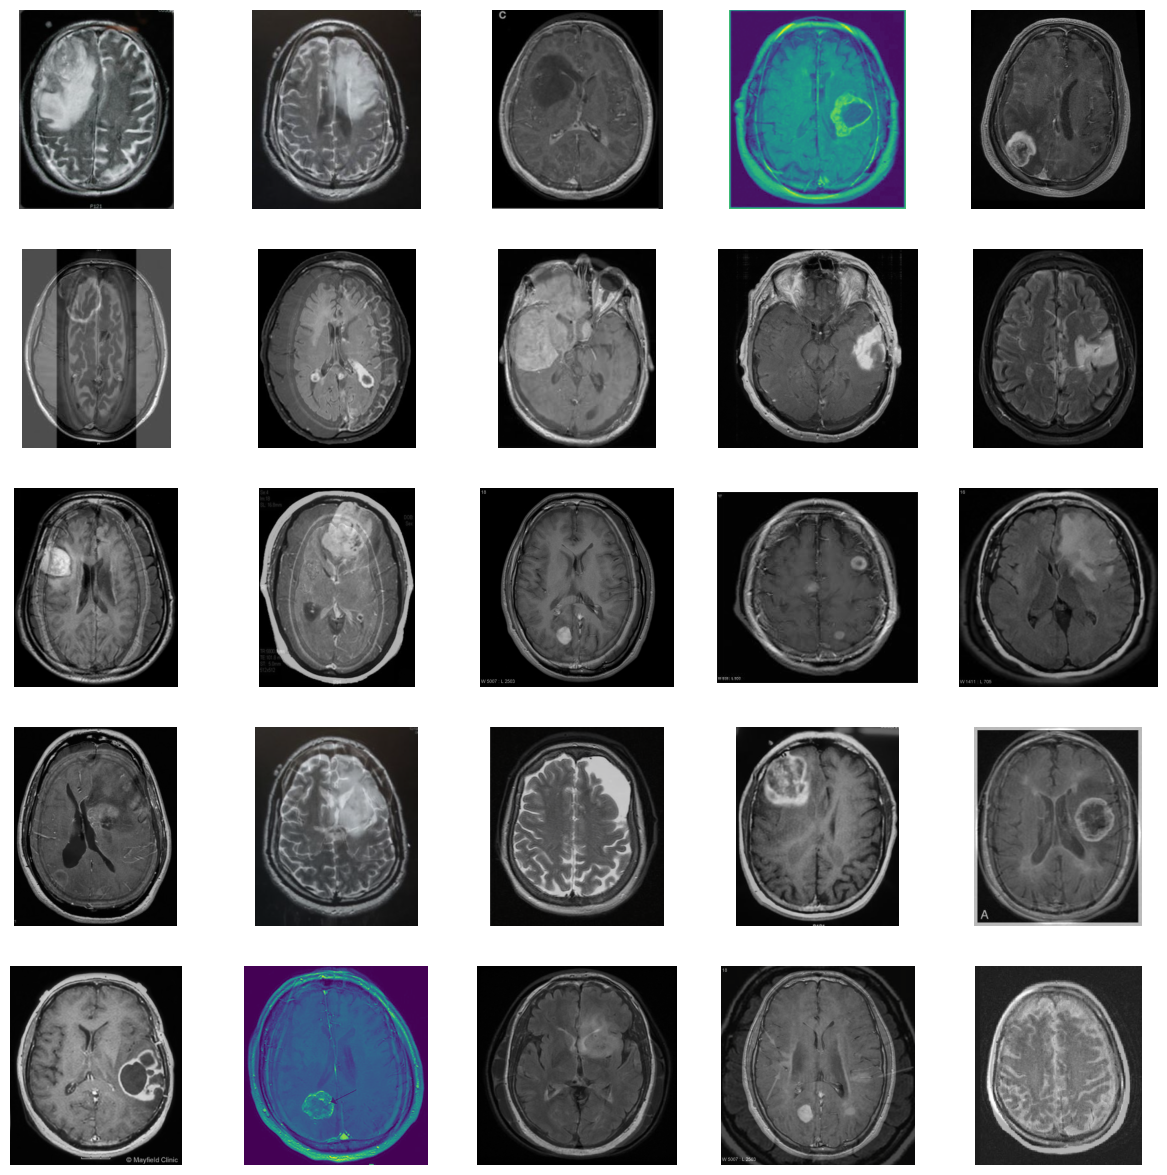

In [44]:
n_rows = 5
n_cols = 5
idx = 0

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,15))
for i in range(n_rows):
    for j in range(n_cols):
        image = plt.imread(image_paths[idx])
        mask = plt.imread(mask_paths[idx])

        # Convert image and mask to tensors
        image_tensor = to_tensor(image)
        mask_tensor = to_tensor(mask)

        # Get the desired shape from the image tensor
        # The shape is (C, H, W), we need (H, W) for Resize
        image_shape = image_tensor.shape[1:]

        # Resize the mask tensor to match the image tensor shape
        # Resize expects input shape (C, H, W) and output shape (H, W)
        resize_transform = Resize(image_shape, antialias=True)
        resized_mask_tensor = resize_transform(mask_tensor)

        # Convert tensors back to numpy arrays for display
        # permute(1, 2, 0) changes shape from (C, H, W) to (H, W, C)
        image_np = image_tensor.permute(1, 2, 0).numpy()
        resized_mask_np = resized_mask_tensor.permute(1, 2, 0).numpy()

        # Overlay mask on image - ensure both are floats for multiplication
        # Convert to float if they are not already
        image_np = image_np.astype(np.float32)
        resized_mask_np = resized_mask_np.astype(np.float32)

        # Check the number of channels in the resized mask
        if resized_mask_np.shape[-1] == 4:
            # If it has 4 channels (RGBA), take only the first 3 (RGB) or a single channel if it's grayscale with alpha
            # Assuming the mask represents a single channel segmentation mask, take the first channel
            resized_mask_np = resized_mask_np[:, :, 0]
        elif resized_mask_np.shape[-1] == 3 and np.allclose(resized_mask_np[:,:,0], resized_mask_np[:,:,1]) and np.allclose(resized_mask_np[:,:,0], resized_mask_np[:,:,2]):
             # If mask is grayscale but loaded as RGB (shape (H, W, 3)), take one channel
             resized_mask_np = resized_mask_np[:,:,0] # Use only one channel


        # If mask is now (H, W) and image is (H, W, 3), expand mask dimensions to (H, W, 1) for broadcasting
        if resized_mask_np.ndim == 2 and image_np.ndim == 3:
            resized_mask_np = np.expand_dims(resized_mask_np, axis=-1)

        # Perform the overlay - ensure shapes are compatible (H, W, C) or (H, W)
        # If image is RGB (H, W, 3) and mask is (H, W, 1), broadcasting will handle it
        # If both are (H, W), it will also work
        # If mask is (H, W, 3), it will work
        # If mask was binary (0 or 1) and became (H, W, 1), multiplying by 0.3 will scale it
        combined = image_np * 0.7 + resized_mask_np * 0.3


        axs[i,j].imshow(combined)
        axs[i,j].axis('off')

        idx+=1

# Ensure to display the plot
plt.show()

# 2.3. Display some statistics of images and masks

In [45]:
def display_statistics(image_path, mask_path):
    image = plt.imread(image_path)
    mask = plt.imread(mask_path)

    print("Image Statistics:")
    print(f"Shape: {image.shape}")
    print(f"Min value: {image.min()}")
    print(f"Max value: {image.max()}")

    print("\nMask Statistics:")
    print(f"Shape: {image.shape}")
    print(f"Min value: {image.min()}")
    print(f"Max value: {image.max()}")
    print(f"Unique values: {np.unique(mask)}")

display_statistics(image_paths[0], mask_paths[0])

Image Statistics:
Shape: (380, 294, 3)
Min value: 0
Max value: 255

Mask Statistics:
Shape: (380, 294, 3)
Min value: 0
Max value: 255
Unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209

# 3. Create a dataset
In this section, we will pre-process and create a Pytorch dataset:

Create a PyTorch Dataset: Develop a custom PyTorch Dataset to manage data loading efficiently.
Resize Images: Adjust the dimensions of the images to a uniform size suitable for the model.
Apply Augmentation: Implement various data augmentations to enhance the dataset and improve model robustness.
Visualize Transformed Images: Display the transformed images and masks to verify the preprocessing steps and understand the effects of the augmentations.

# 3.1. Define a dataset class

In [49]:
from torchvision.transforms.functional import to_tensor, resize
import torchvision # Add this line to import the torchvision module

class BrainMRIDataset(Dataset):
    def __init__(self, image_paths, mask_paths):
        self.image_paths = sorted(image_paths)
        self.mask_paths = sorted(mask_paths)
        # Define a target size for initial resize
        self.target_size = (128, 128) # Height, Width
        self.transform = A.Compose([
            # We remove A.Resize here because we handle initial resize before this compose
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load images and masks using plt.imread
        image = plt.imread(image_path)
        mask = plt.imread(mask_path)

        # Ensure image and mask are numpy arrays (plt.imread does this)
        # Ensure they are in a suitable format for transforms (e.g., uint8 or float32)
        # Albumentations works best with uint8 or float32

        # Resize image and mask to a consistent size before applying albumentations
        # Use torchvision.transforms.functional.resize
        # Need to convert numpy array to PyTorch tensor first for torchvision resize
        # Then convert back to numpy array for Albumentations
        # Handle potential channel mismatch after loading
        # Assuming images are RGB and masks are grayscale (or can be treated as grayscale)
        # Convert image to RGB if it's grayscale
        if image.ndim == 2:
            image = np.stack([image] * 3, axis=-1) # Convert HxW to HxWx3
        # If mask is RGB or RGBA, convert to grayscale (HxW)
        if mask.ndim == 3:
             # Assuming single channel mask stored in one of the channels
             # We can take the first channel, or convert to grayscale
             # Let's assume it's a binary mask and take the first channel
             mask = mask[:, :, 0]
             # Ensure mask is binary if it's not already (e.g., thresholding)
             # mask = (mask > 0).astype(np.uint8) # Example thresholding if needed

        # Convert to tensor for torchvision resize
        # torchvision expects (C, H, W)
        image_tensor = to_tensor(image).float() # Ensure float for potential scaling
        mask_tensor = to_tensor(mask).float() # Ensure float

        # Resize tensors
        # antialias=True is recommended for image quality
        # interpolation='nearest' is suitable for masks to preserve discrete labels
        image_resized_tensor = resize(image_tensor, self.target_size, antialias=True)
        mask_resized_tensor = resize(mask_tensor, self.target_size, antialias=False, interpolation=torchvision.transforms.InterpolationMode.NEAREST) # Use NEAREST for masks

        # Convert back to numpy for Albumentations (Albumentations expects HxWxD or HxW)
        # Permute from (C, H, W) to (H, W, C) for Albumentations if it's an image
        # Keep as (H, W) for mask if it's single channel
        image_resized_np = image_resized_tensor.permute(1, 2, 0).numpy()
        # Remove channel dimension for mask if it's (1, H, W)
        mask_resized_np = mask_resized_tensor.squeeze(0).numpy()

        # Ensure data types are suitable for Albumentations (uint8 or float32)
        # Assuming image values are in [0, 255] initially, convert to uint8
        # Assuming mask values are binary (0 or 1), keep as float or convert to uint8
        image_resized_np = (image_resized_np * 255).astype(np.uint8) # Scale back to 0-255 and convert to uint8
        mask_resized_np = (mask_resized_np).astype(np.uint8) # Keep as uint8 for mask labels


        # Apply albumentations transform
        if self.transform:
            # Pass resized numpy arrays to albumentations
            augmented = self.transform(image=image_resized_np, mask=mask_resized_np)
            image = augmented['image'] # This will be a PyTorch tensor (C, H, W) due to ToTensorV2
            mask = augmented['mask']   # This will be a PyTorch tensor (C, H, W) or (H, W)

            # Ensure mask is single channel if necessary for training (usually (1, H, W))
            if mask.ndim == 3 and mask.shape[0] > 1:
                 mask = mask[0, :, :].unsqueeze(0) # Take the first channel and keep (1, H, W) shape


        return image, mask

# Re-initialize dataset and get an item
dataset = BrainMRIDataset(image_paths, mask_paths)
image, mask = dataset[0]
print(image.shape, mask.shape)

torch.Size([3, 128, 128]) torch.Size([128, 128])


# 3.2. Visualize some augmented images and masks from the dataset

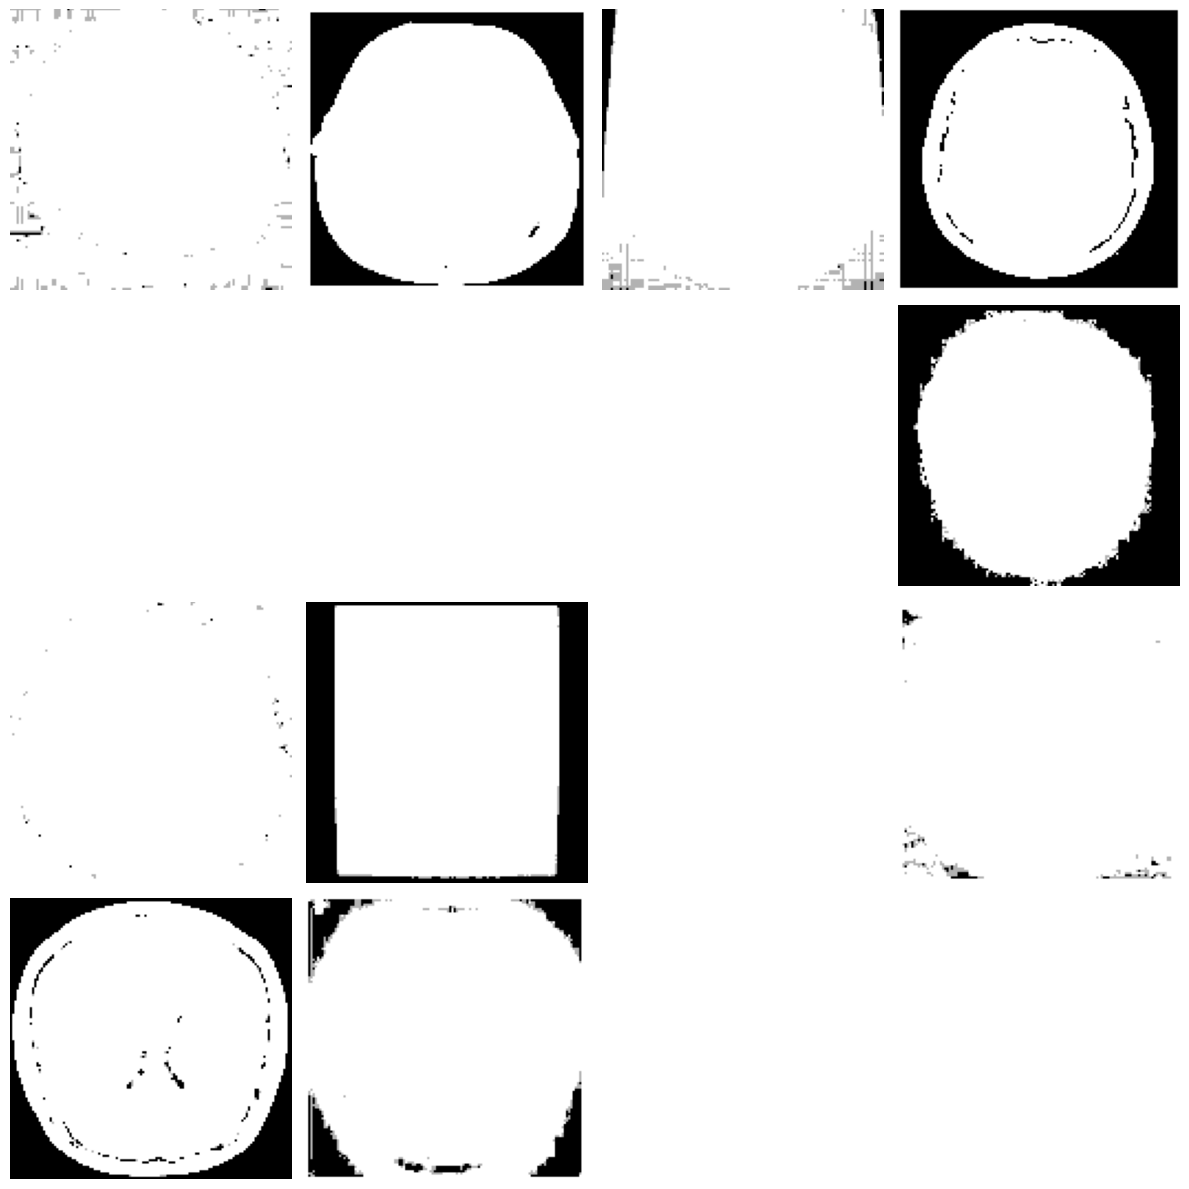

In [50]:
def plot_images_with_masks(dataset, num_images=16):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(num_images):
        image, mask = dataset[i]

        # Convert tensor to numpy array
        image = image.permute(1, 2, 0).numpy()
        mask = mask.numpy()

        # Overlay mask on image
        overlay = np.zeros_like(image)
        overlay[...,0] = mask

        combined = image * 0.7 + overlay * 0.3

        axes[i].imshow(combined)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
plot_images_with_masks(dataset)

# 4. Model

In [51]:
# Define the U-Net model with pre-trained weights
model = smp.Unet(
    encoder_name="resnet34",
    in_channels=1,
    classes=1,
    activation='sigmoid'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [52]:
# Print model statistics
def print_model_statistics(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total number of learnable parameters: {total_params:,}')

print_model_statistics(model)

Total number of learnable parameters: 24,430,097


# 5. Define loss function, evaluation metric, and optimizer

# 5.1. Loss function

# Loss Function
In deep learning, a loss function measures the difference between the predicted output and the actual target. It serves as a guide for the optimization process, helping the model to learn and improve by minimizing this difference. The choice of loss function can significantly impact the model's performance, especially in tasks like semantic segmentation.

# Dice Loss
Dice Loss is specifically designed for segmentation tasks and is derived from the Dice Similarity Coefficient. It measures the overlap between the predicted segmentation and the ground truth, making it particularly effective for handling imbalanced datasets where some classes may be underrepresented. The Dice Loss ranges from 0 to 1, where a lower value indicates better performance.

# Other Loss Functions for Semantic Segmentation
Cross-Entropy Loss Cross-Entropy Loss is widely used for classification tasks, including semantic segmentation. It measures the difference between the predicted probability distribution and the true distribution.

In [56]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

Binary Cross-Entropy Loss This loss function is used for binary segmentation tasks. It is a special case of Cross-Entropy Loss for binary classification.

In [57]:
import torch.nn as nn

criterion = nn.BCELoss()

Focal Loss Focal Loss is designed to address class imbalance by down-weighting the loss for well-classified examples and focusing more on hard-to-classify examples.

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
  def __init__(self, alpha=1, gamma=2):
      super(FocalLoss, self).__init__()
      self.alpha = alpha
      self.gamma = gamma

  def forward(self, inputs, targets):
      BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
      pt = torch.exp(-BCE_loss)
      F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
      return F_loss.mean()

criterion = FocalLoss()
loss = criterion(preds, target)

IoU Loss IoU Loss directly optimizes the Intersection over Union metric, making it suitable for segmentation tasks where IoU is a critical evaluation metric.

In [60]:
import torch
import torch.nn.functional as F

def iou_loss(preds, target, smooth=1e-6):
  intersection = (preds * target).sum()
  total = (preds + target).sum()
  union = total - intersection
  IoU = (intersection + smooth) / (union + smooth)
  return 1 - IoU

# Define dummy preds and target for demonstration
# In a real scenario, these would come from your model's output and your data loader
preds = torch.randn(1, 1, 128, 128).sigmoid() # Example: batch_size=1, channels=1, size=128x128
target = torch.randint(0, 2, (1, 1, 128, 128)).float() # Example: binary mask

# Calculate the loss using the dummy tensors
loss = iou_loss(preds, target)

print(f"Calculated IoU loss: {loss.item()}")

Calculated IoU loss: 0.6635057926177979


In [62]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# 5.2. Evaluation metric

# Dice Score
* Dice Score, also known as the Dice Similarity Coefficient (DSC), is a popular evaluation metric used in image segmentation tasks. It measures the overlap between the predicted segmentation and the ground truth, providing a value between 0 and 1, where 1 indicates perfect overlap.
* Dice Score is particularly useful in medical imaging, where accurate segmentation is crucial.
* The torchmetrics library provides a Dice metric class that simplifies the process of computing the Dice Score, ensuring consistency and reliability in your evaluations.
# Other Metrics for Semantic Segmentation
### Intersection over Union (IoU)


The IoU metric, also known as the Jaccard Index, measures the overlap between the predicted segmentation and the ground truth. It is calculated as the ratio of the intersection to the union of the two sets.

In [65]:
from torchmetrics import JaccardIndex
num_classes = 2
iou = JaccardIndex(num_classes=num_classes , task='binary')
iou_score = iou(preds, target)

### Pixel Accuracy

Pixel accuracy computes the ratio of correctly classified pixels to the total number of pixels.

In [66]:
import torch

def pixel_accuracy(preds, target):
  correct = torch.eq(preds, target).int()
  accuracy = correct.sum() / correct.numel()
  return accuracy

accuracy = pixel_accuracy(preds, target)

### Precision, Recall, and F1 Score

These metrics provide insights into the performance of the model in terms of true positives, false positives, and false negatives.

In [68]:
from torchmetrics import Precision, Recall, F1Score

precision = Precision(num_classes=num_classes, average='macro', task='binary')
recall = Recall(num_classes=num_classes, average='macro', task='binary')
f1 = F1Score(num_classes=num_classes, average='macro', task='binary')

precision_score = precision(preds, target)
recall_score = recall(preds, target)
f1_score = f1(preds, target)

### Mean Absolute Error (MAE)
MAE measures the average magnitude of the errors between the predicted and actual values.

In [69]:
from torchmetrics import MeanAbsoluteError

mae = MeanAbsoluteError()
mae_score = mae(preds.float(), target.float())

In [74]:
from torchmetrics.segmentation import DiceScore

# Removed the 'task' argument as it's not expected by DiceScore
dice_metric = DiceScore(num_classes=2)

# 5.3. Optimizer

## Optimizer
In deep learning, an optimizer is an algorithm used to adjust the weights of the neural network to minimize the loss function. It plays a crucial role in the training process by guiding the model towards better performance through iterative updates. Optimizers can significantly impact the convergence speed and the quality of the final model.

## Adam Optimizer
The Adam (Adaptive Moment Estimation) optimizer is a popular choice for training deep learning models. It combines the advantages of two other extensions of stochastic gradient descent, namely AdaGrad and RMSProp. Adam computes adaptive learning rates for each parameter, making it well-suited for problems with large datasets and high-dimensional parameter spaces. Its ability to adjust learning rates dynamically helps in achieving faster convergence and better performance.

## Other optimizers
**SGD (Stochastic Gradient Descent)**

In [76]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

**RMSprop**

In [77]:
import torch.optim as optim
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

**Adagrad**

In [78]:
import torch.optim as optim
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

**AdamW**

In [79]:
import torch.optim as optim
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [80]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 6. Training process

# 6.1. Split data into train, validation, and test sets

In [83]:
# Split data to train and test sets
from sklearn.model_selection import train_test_split, KFold

image_filenames = os.listdir(image_dir)

# Create full paths for images
image_paths = [os.path.join(image_dir, filename) for filename in image_filenames]

# Assuming mask filenames are the same as image filenames and are in the mask_dir
# You should verify if this is true for your dataset
mask_paths = [os.path.join(mask_dir, filename) for filename in image_filenames]


# Check if the number of image files equals the number of mask files collected this way
if len(image_paths) != len(mask_paths):
    print(f"Warning: Mismatch between number of image files ({len(image_paths)}) and mask files ({len(mask_paths)}).")
    # Here you would need to investigate why they don't match.
    # For example, are some masks missing? Are mask files named differently?
    # If you cannot proceed with the mismatch, you might raise an error or filter the lists.
    # For now, we will proceed, which will still lead to the error if the lengths don't match.
    # You must resolve the data mismatch before train_test_split will work.
    # A common scenario is that you need to match filenames, not just list directories.
    # Example: Create pairs (image_path, mask_path) and then split these pairs.

    # # Example of creating pairs and filtering for matching files (if filenames are identical)
    # image_filenames_set = set(os.listdir(image_dir))
    # mask_filenames_set = set(os.listdir(mask_dir))
    #
    # common_filenames = list(image_filenames_set.intersection(mask_filenames_set))
    #
    # image_paths = [os.path.join(image_dir, fn) for fn in common_filenames]
    # mask_paths = [os.path.join(mask_dir, fn) for fn in common_filenames]
    #
    # print(f"Using {len(image_paths)} image-mask pairs found with matching filenames.")


# Now, image_paths and mask_paths should have the same length
# if the file collection logic above correctly captured corresponding pairs.
# If the data structure is different (e.g., mask filenames have a different prefix/suffix
# or are in subdirectories), you need to adjust the code to find the correct pairs.


train_image_paths, valtest_image_paths, train_mask_paths, valtest_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=RANDOM_SEED
)
val_image_paths, test_image_paths, val_mask_paths, test_mask_paths = train_test_split(
    valtest_image_paths, valtest_mask_paths, test_size=0.5, random_state=RANDOM_SEED
)
n_train = len(train_image_paths)
n_val = len(val_image_paths)
n_test = len(test_image_paths)
print(f'{n_train} train images, {n_val} validation images, {n_test} test images.')

124 train images, 15 validation images, 16 test images.


# 6.2. Define training functions

In [84]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    dice_metric = Dice().to(device)

    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        dice_metric.update(outputs, masks.int())

    train_loss /= len(train_loader.dataset)
    dice_score = dice_metric.compute().item()

    return train_loss, dice_score

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    dice_metric = Dice().to(device)

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            dice_metric.update(outputs, masks.int())

    val_loss /= len(val_loader.dataset)
    dice_score = dice_metric.compute().item()

    return val_loss, dice_score

In [85]:
def train_and_validate(train_image_paths, train_mask_paths,
                       val_image_paths, val_mask_paths,
                       model, device, num_epochs, batch_size):

    train_dataset = BrainMRIDataset(train_image_paths, train_mask_paths)
    val_dataset = BrainMRIDataset(val_image_paths, val_mask_paths)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    model = model.to(device)
    criterion = DiceLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_dices = []
    val_dices = []

    for epoch in range(num_epochs):
        train_loss, train_dice = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_dice = validate_one_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_dices.append(train_dice)
        val_dices.append(val_dice)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/kaggle/working/best_model.pth')

    return train_losses, val_losses, train_dices, val_dices